In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import numpy as np
import calendar
import sys,os
import sqlite3
from dateutil import parser

In [18]:
# connect to DB
SRC_DIR = os.path.dirname(os.getcwd())
dbname = "quickbooks.db"
dbpath = os.path.join(SRC_DIR,"db",dbname)
conn = sqlite3.connect(dbpath) 
alldf = pd.read_sql("select * from categorized_items", conn, parse_dates=['Date'])

In [19]:
budget_file = os.path.join(SRC_DIR,'config','qb_to_budget_map.csv')
budgetdf = pd.read_csv(budget_file)

In [20]:
# Date information
year = 2023
month = 8 # month number (i.e. 4 for April)
days = calendar.monthrange(year,month)[1]
month_name = calendar.month_name[month]

In [21]:
print(f"Grabbing report details for {month_name}")
interval = (f"{year}-{month}-01",f"{year}-{month+1}-01")
interval_dates = (parser.parse(interval[0]),parser.parse(interval[1]))
qbdf = alldf.loc[(alldf['Date']>=interval_dates[0]) & (alldf['Date']<interval_dates[1])]

Grabbing report details for August


In [22]:
# data manipulation
qbdf['item'] = qbdf['category'].apply(lambda x: x.split(':')[-1])
qbdf['Amount'] = qbdf['Amount'].astype(float)
qbdf['Account_Type'] = qbdf['category'].apply(lambda x: x.split(':')[0])

budgetdf['Budget'] = budgetdf['Budget']
budget_items = budgetdf['QB_Item'].unique()

expenses = qbdf.loc[qbdf['Account_Type']=='Expenses']
income = qbdf.loc[qbdf['Account_Type'] == 'Income']

# check for unrecognized types and categories
types = qbdf["Transaction Type"].unique()
expected_types = ['Check','Expense','Deposit']
for t in types:
    if t not in expected_types:
        print(f"Warning: {t} not a recognized type")

for item in expenses['item'].unique():
    if item not in budget_items:
        print(f"Warning: {item} not in any budget category")

In [14]:
item_totals = expenses.groupby('item').aggregate({"Amount":"sum","Date":'count'}).reset_index()
item_totals.columns = ['item','Amount','Transactions']
all_totals = pd.merge(budgetdf,item_totals, left_on='QB_Item', right_on="item", how = 'left')
subcategory_totals = all_totals.groupby("Subcategory").aggregate({"Budget":"sum","Amount":"sum"}).reset_index()

In [15]:
total_expense = expenses['Amount'].sum()
total_income = income['Amount'].sum()
net_profit = total_income - total_expense

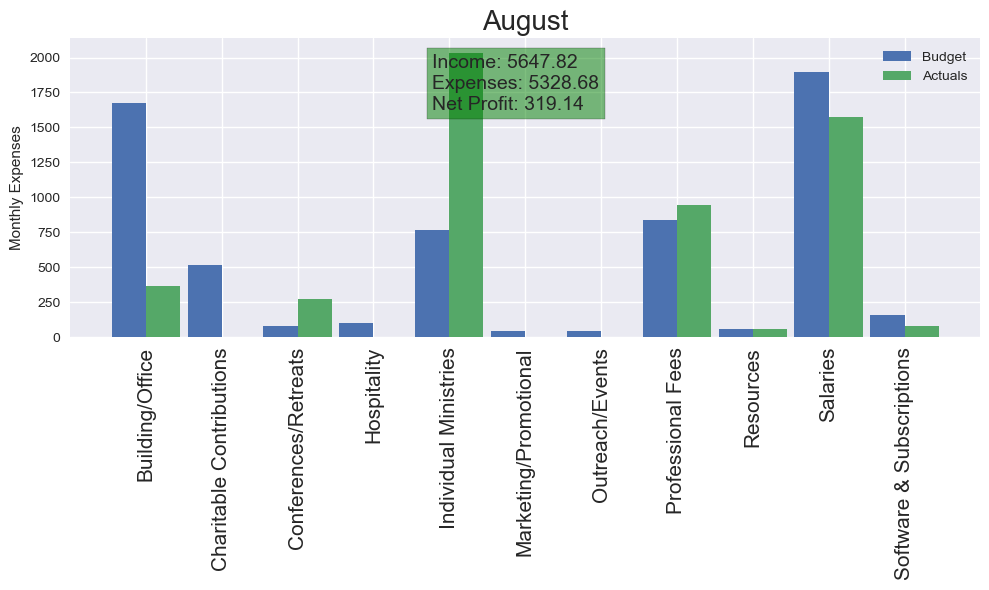

In [16]:
fig, ax = plt.subplots(figsize = (10,6))
ind = np.arange(len(subcategory_totals))
width = 0.45
budget = ax.bar(ind, subcategory_totals['Budget'], width, label = "Budget")
actual = ax.bar(ind+width, subcategory_totals["Amount"], width, label="Actuals")
ax.set_ylabel("Monthly Expenses")
ax.set_title(month_name, fontsize=20)
midx = ind.mean()
midy = max([subcategory_totals['Budget'].max(), subcategory_totals["Amount"].max()])*0.8
color = 'green'
if net_profit>0:
    color = 'green'
else:
    color = 'red'
ax.text(midx-1, midy, 'Income: {:.2f}\nExpenses: {:.2f}\nNet Profit: {:.2f}'.format(total_income,total_expense, net_profit), fontsize=14, bbox=dict(facecolor=color, alpha=0.5))
ax.legend()

ax.set_xticks(ind+width/2, subcategory_totals['Subcategory'], rotation=90, fontsize=15)
plt.tight_layout()
plt.savefig(f'{month_name}.png')

In [29]:
report_totals = all_totals[~all_totals['item'].isin(['Lead Pastor','Associate Pastor'])].sort_values(['Amount'], ascending=False).head(10)[['Item', 'Budget', 'Amount', 'Transactions']]
report_totals['Transactions'] = report_totals['Transactions'].astype(int)

In [30]:
report_totals

,Item,Budget,Amount,Transactions
13,Utilities,462.50,629.17,1
16,Lawn/Snow Service,125.00,396.28,5
36,Life Network,129.00,377.00,1
37,Joel Frees,129.00,377.00,1
38,Crossfire,129.00,377.00,1
15,Cleaning Service,217.00,300.00,1
5,Communications,81.25,162.46,2
4,Equipment,42.00,162.29,1
24,Worship,83.00,116.58,3
33,Church Outreach,42.00,112.95,1


In [21]:
all_totals.sort_values("Amount", ascending=False)

,Category,Subcategory,Item,QB_Item,Budget,item,Amount
0,Salaries,Salaries,Lead Pastor,Lead Pastor,1300.00,Lead Pastor,1200.00
1,Salaries,Salaries,Associate Pastor,Associate Pastor,600.00,Associate Pastor,750.00
30,Ministry,Individual Ministries,Honorarium/Blessing,Honorarium/Blessing,250.00,Honorarium/Blessing,500.00
22,Ministry,Individual Ministries,Pastoral Expense,Pastoral Expenses,83.00,Pastoral Expenses,350.45
13,Facilities,Professional Fees,Utilities,Utilities,462.50,Utilities,302.72
16,Facilities,Professional Fees,Lawn/Snow Service,Lawn/Snow,125.00,Lawn/Snow,300.00
20,Facilities,Hospitality,"Food for Events, Sunday Morning",Food for Events/Sunday Morning,42.00,Food for Events/Sunday Morning,158.26
27,Ministry,Individual Ministries,Student Ministry,Student Ministry,42.00,Student Ministry,106.73
3,Facilities,Building/Office,Office Supplies,Office Supplies,42.00,Office Supplies,84.43
21,Facilities,Software & Subscriptions,Software & Subscriptions,Software and Subscriptions,156.00,Software and Subscriptions,77.23


In [42]:
special_account = qbdf[qbdf['item']=='Worship Contribution']

Text(0.5, 0, 'Date')

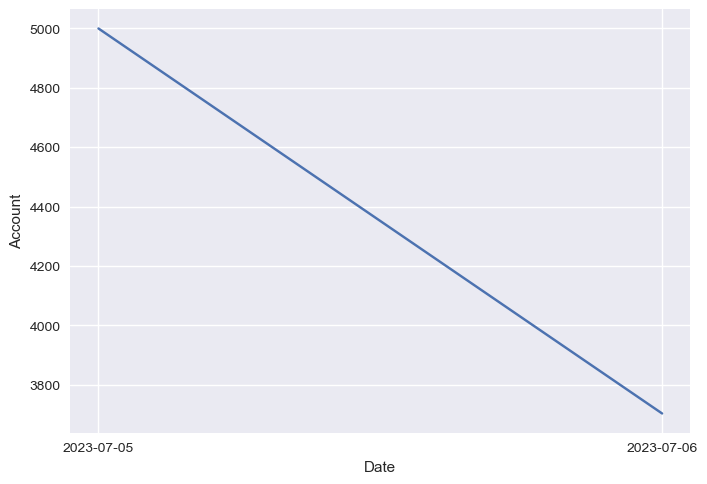

In [41]:
fig, ax = plt.subplots()
ax.plot(special_account['Date'],special_account['Balance'].astype(float))
ax.set_ylabel("Account")
ax.set_xlabel("Date")

In [43]:
special_account[['Date'],]

,Date,Transaction Type,Num,Name,Memo/Description,Split,Amount,Balance,category,category_level,item
13,2023-07-05,Deposit,,,Charitable contribution,1002 ENT Checking (Keystone),5000.00,5000.00,Income:Tithe:Worship Contribution,3,Worship Contribution
14,2023-07-06,Expense,,Amazon,New sound snake - Amazon,1002 ENT Checking (Keystone),-1297.32,3702.68,Income:Tithe:Worship Contribution,3,Worship Contribution


In [45]:
income['item'].unique()

array(['Interest Earned', 'Olive Tree (Tenant Lease)', 'General Tithe',
       'Worship Contribution'], dtype=object)